# EMG Gesture Classification: Comparative Analysis of Deep Learning Architecture

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from typing import Tuple, List, Dict
import os

In [2]:

# Load the dataset from a CSV file.
df = pd.read_csv("data/processed/EMG-data.csv")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def print_color(text: str, color: str) -> None:
    """
    Prints text in specified ANSI color for better readability in notebooks.
    
    Args:
        text (str): Text to be printed
        color (str): Color name ('red', 'green', 'yellow', 'blue', 'magenta')
    """
    colors = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m"
    }
    print(f"{colors.get(color, '')}{text}\033[0m")


In [4]:

def plot_emg_channels(data: np.ndarray, title: str = "EMG Signals", 
                      sample_idx: int = 0, channels: int = 8) -> None:
    """
    Plot EMG channels from a window of data.
    
    Args:
        data (np.ndarray): EMG data array with shape (windows, time_steps, channels)
        title (str): Title for the plot
        sample_idx (int): Index of the window to plot
        channels (int): Number of EMG channels
    """
    plt.figure(figsize=(12, 16))
    window_data = data[sample_idx]
    for i in range(channels):
        plt.subplot(channels, 1, i + 1)
        plt.plot(window_data[:, i])
        plt.title(f'{title}, Channel {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

def create_sliding_windows(data: np.ndarray, labels: np.ndarray, 
                          window_size: int, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sliding windows from EMG data for time series analysis.
    
    Args:
        data (np.ndarray): EMG data as a numpy array
        labels (np.ndarray): Corresponding labels
        window_size (int): Size of each window
        step_size (int): Step size between consecutive windows
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Windowed data and corresponding labels
    """
    X_list = []
    y_list = []
    
    for i in range(0, len(data) - window_size + 1, step_size):
        X_list.append(data[i:i + window_size])
        # Use the most frequent label in the window
        y_list.append(labels[i + window_size // 2])  # Take the middle point's label
    
    return np.array(X_list), np.array(y_list)


Head of DataFrame:
   Channel_1  Channel_2  Channel_3  Channel_4  Channel_5  Channel_6  \
0         -4        -11        -39        -18         -1          1   
1          2         12          5          9          1          0   
2         29         27         24         19        -46        -14   
3        -33        -28         -9         44         63         13   
4         39        -36        -50         22          8          0   

   Channel_7  Channel_8  subject  repetition  gesture  
0         -2         -1        1           1        0  
1        -14        -20        1           1        0  
2        -19         21        1           1        0  
3         19         15        1           1        0  
4        -17         -3        1           1        0  
Shape of DataFrame:
(664666, 11)
Null values in each column:
Channel_1     0
Channel_2     0
Channel_3     0
Channel_4     0
Channel_5     0
Channel_6     0
Channel_7     0
Channel_8     0
subject       0
repetition   

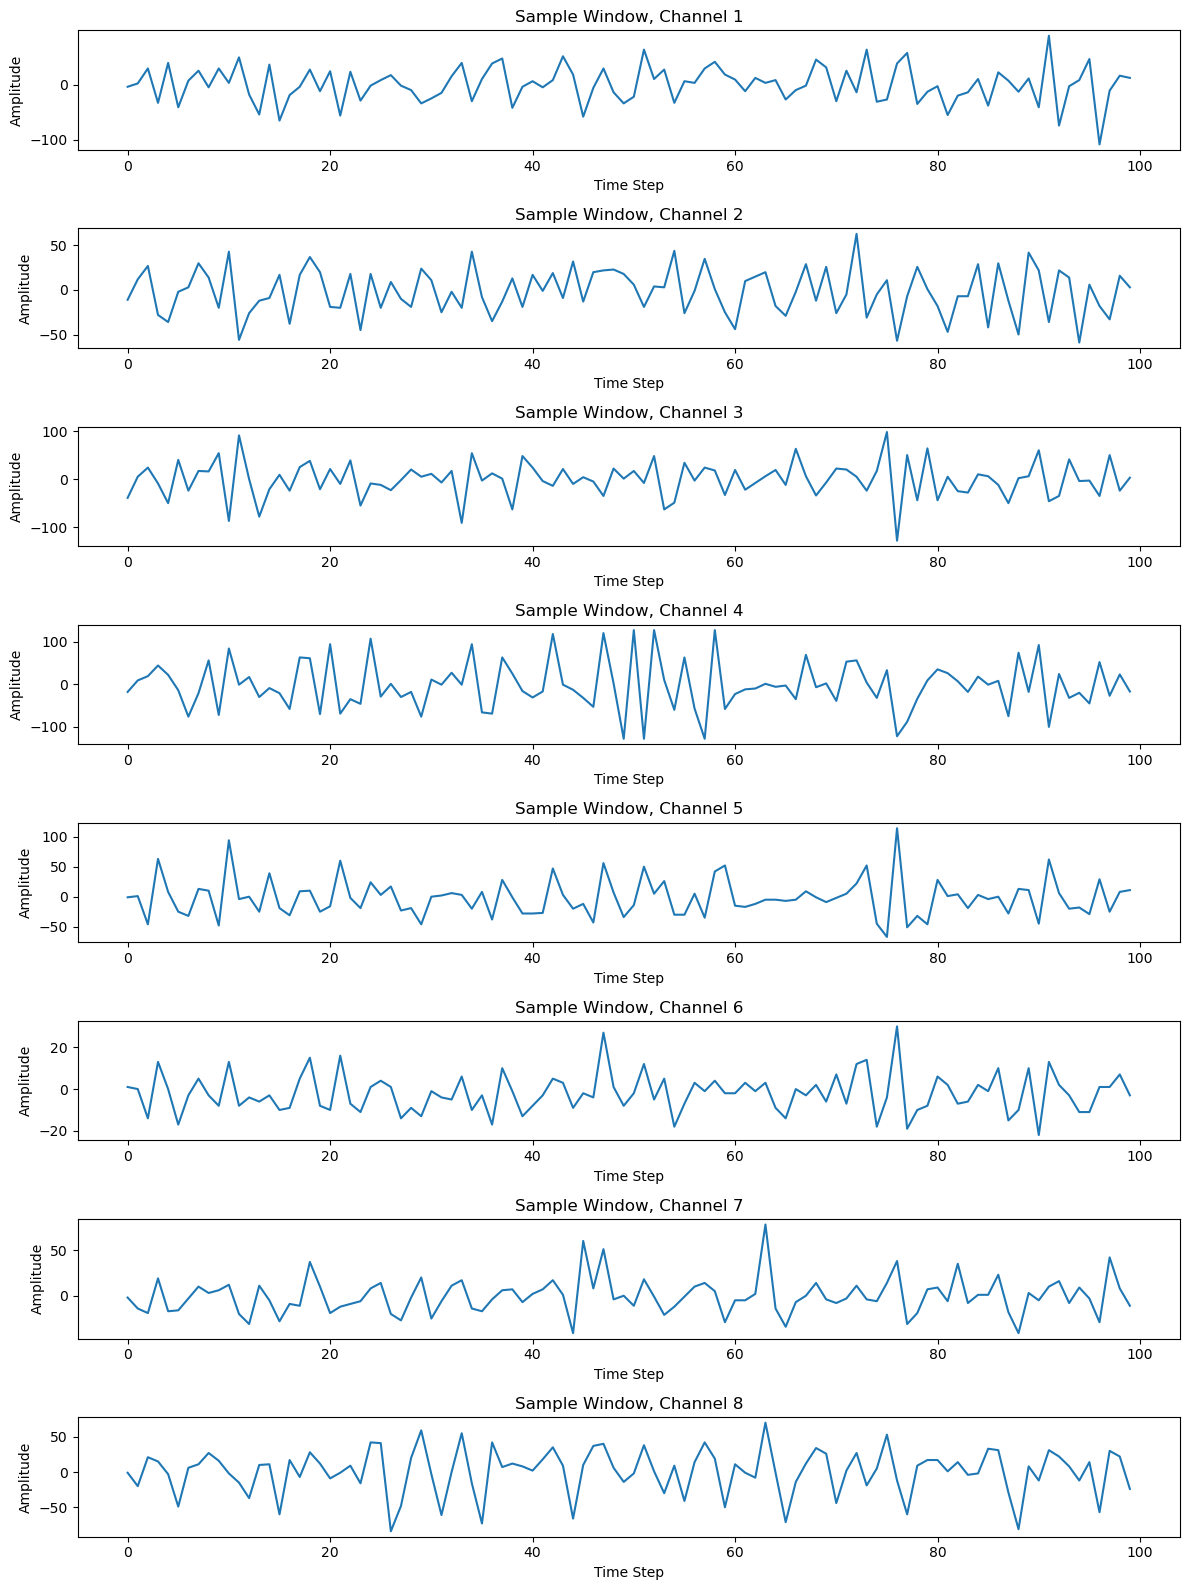

In [5]:
# Adjust gesture labels to be zero-indexed
df['gesture'] = df['gesture'] - 1

# Count number of unique gestures
num_classes = df['gesture'].nunique()

# Explore dataset
print_color("Head of DataFrame:", "green")
print(df.head())

print_color("Shape of DataFrame:", "green")
print(df.shape)

# Check for null values
null_count = df.isnull().sum()
print_color("Null values in each column:", "yellow")
print(null_count)

# Dataset properties
print_color("Unique gestures (zero-indexed):", "blue")
print(sorted(df["gesture"].unique()))

print_color("Unique subjects:", "blue")
print(sorted(df["subject"].unique()))


# Cell 5: Windowing for feature extraction
# Set window size and step size for slicing the data
WINDOW_SIZE = 100  # Number of samples per window
STEP_SIZE = 50     # Interval between consecutive windows

# Extract channel data
channel_cols = [f'Channel_{i}' for i in range(1, 9)]
X_list = []
y_list = []

# Group the data by gesture and create windows
for gesture_id in sorted(df["gesture"].unique()):
    gesture_df = df[df["gesture"] == gesture_id]
    gesture_data = gesture_df[channel_cols].values
    
    # Generate overlapping windows of data
    for start_idx in range(0, len(gesture_data) - WINDOW_SIZE + 1, STEP_SIZE):
        window_data = gesture_data[start_idx:start_idx + WINDOW_SIZE]
        X_list.append(window_data)
        y_list.append(gesture_id)

# Convert lists to NumPy arrays
X_array = np.array(X_list)
y_array = np.array(y_list)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_array, dtype=torch.float32)
y_tensor = torch.tensor(y_array, dtype=torch.long)

# Move tensors to device
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# Save tensors for later use (optional)
os.makedirs('data', exist_ok=True)
torch.save(X_tensor, "data/X_emg.pt")
torch.save(y_tensor, "data/y_emg.pt")

# Display shapes and stats
print_color("Shape of X_tensor:", "red")
print(X_tensor.shape)
print_color("Shape of y_tensor:", "red")
print(y_tensor.shape)

# Print data statistics
print_color("Data statistics in X_tensor:", "green")
print(f"Mean: {torch.mean(X_tensor).item():.4f}")
print(f"Standard Deviation: {torch.std(X_tensor).item():.4f}")
print(f"Max value: {torch.max(X_tensor).item():.4f}")
print(f"Min value: {torch.min(X_tensor).item():.4f}")

# Cell 6: Visualize windowed data
# Load the windowed data (if previously saved)
# X_tensor = torch.load("data/X_emg.pt")
X_numpy = X_tensor.cpu().numpy()

# Plot a sample window
plot_emg_channels(X_numpy, title="Sample Window", sample_idx=0)


Data splitting

In [6]:
# Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    X_tensor.cpu().numpy(),
    y_tensor.cpu().numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_tensor.cpu().numpy()  # Ensure class balance in splits
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    random_state=RANDOM_SEED,
    stratify=y_temp  # Maintain class balance
)

# Convert back to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Output the shapes of the datasets
print("Dataset splits:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_train == c).item()} samples")

print("\nClass distribution in validation set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_val == c).item()} samples")

print("\nClass distribution in test set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_test == c).item()} samples")



Dataset splits:
x_train shape: torch.Size([10627, 100, 8])
y_train shape: torch.Size([10627])
x_val shape: torch.Size([1328, 100, 8])
y_val shape: torch.Size([1328])
x_test shape: torch.Size([1329, 100, 8])
y_test shape: torch.Size([1329])

Class distribution in training set:
Class 0: 1520 samples
Class 1: 1519 samples
Class 2: 1518 samples
Class 3: 1519 samples
Class 4: 1516 samples
Class 5: 1517 samples
Class 6: 1518 samples

Class distribution in validation set:
Class 0: 190 samples
Class 1: 190 samples
Class 2: 190 samples
Class 3: 190 samples
Class 4: 190 samples
Class 5: 189 samples
Class 6: 189 samples

Class distribution in test set:
Class 0: 190 samples
Class 1: 190 samples
Class 2: 190 samples
Class 3: 190 samples
Class 4: 189 samples
Class 5: 190 samples
Class 6: 190 samples


Data normalization

In [7]:

# Move tensors to CPU for normalization
x_train_cpu = x_train
x_val_cpu = x_val
x_test_cpu = x_test

# Reshape for easier normalization
train_reshaped = x_train_cpu.numpy().reshape(-1, x_train_cpu.shape[-1])
val_reshaped = x_val_cpu.numpy().reshape(-1, x_val_cpu.shape[-1])
test_reshaped = x_test_cpu.numpy().reshape(-1, x_test_cpu.shape[-1])

# Calculate mean and std from training data only (to prevent data leakage)
mean = np.mean(train_reshaped, axis=0)
std = np.std(train_reshaped, axis=0)

# Prevent division by zero
std[std < 1e-10] = 1.0

# Normalize data
train_reshaped = (train_reshaped - mean) / std
val_reshaped = (val_reshaped - mean) / std
test_reshaped = (test_reshaped - mean) / std

# Reshape back to original format
x_train_norm = torch.tensor(train_reshaped.reshape(x_train_cpu.shape), dtype=torch.float32)
x_val_norm = torch.tensor(val_reshaped.reshape(x_val_cpu.shape), dtype=torch.float32)
x_test_norm = torch.tensor(test_reshaped.reshape(x_test_cpu.shape), dtype=torch.float32)

# Save normalization parameters for future use
normalization_params = {
    'mean': mean,
    'std': std
}
np.save('data/normalization_params.npy', normalization_params)

# Move normalized data to device
x_train_norm = x_train_norm.to(device)
x_val_norm = x_val_norm.to(device)
x_test_norm = x_test_norm.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)

# Print shapes to confirm dimensions
print("\nNormalized data shapes:")
print(f"x_train_norm shape: {x_train_norm.shape}")
print(f"x_val_norm shape: {x_val_norm.shape}")
print(f"x_test_norm shape: {x_test_norm.shape}")



Normalized data shapes:
x_train_norm shape: torch.Size([10627, 100, 8])
x_val_norm shape: torch.Size([1328, 100, 8])
x_test_norm shape: torch.Size([1329, 100, 8])


In [8]:

# Cell 9: Convert labels to one-hot encoding for classification
# Convert class vectors to one-hot encoded tensors
y_train_oh = F.one_hot(y_train, num_classes=num_classes).float()
y_val_oh = F.one_hot(y_val, num_classes=num_classes).float()
y_test_oh = F.one_hot(y_test, num_classes=num_classes).float()

# Output the shapes to verify correct dimensions
print("\nOne-hot encoded label shapes:")
print(f"y_train_oh shape: {y_train_oh.shape}")
print(f"y_val_oh shape: {y_val_oh.shape}")
print(f"y_test_oh shape: {y_test_oh.shape}")

# Print an example to verify encoding
print(f"\nExample one-hot encoded label (class {y_test[0].item()}):")
print(y_test_oh[0])



One-hot encoded label shapes:
y_train_oh shape: torch.Size([10627, 7])
y_val_oh shape: torch.Size([1328, 7])
y_test_oh shape: torch.Size([1329, 7])

Example one-hot encoded label (class 6):
tensor([0., 0., 0., 0., 0., 0., 1.], device='cuda:0')


## Models architecture

In [9]:
class CNN1D(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNN1D, self).__init__()

        # Convolution Block 1
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.drop1 = nn.Dropout(0.2)

        # Convolution Block 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * (win_size // 4), 128)  # Adjust input size after pooling
        self.drop3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = torch.flatten(x, start_dim=1)  # Flatten before fully connected layer
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)  # No softmax (handled by CrossEntropyLoss)

        return x  # Returns raw logits

# Example usage:
model = CNN1D(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


CNN1D(
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [10]:
class BiLSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(BiLSTMModel, self).__init__()

        # LSTM layers with bidirectional=True
        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, dropout=0.2, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=64*2, hidden_size=64, batch_first=True, dropout=0.2, bidirectional=True)  # doubled hidden size

        # Fully Connected Layers
        self.fc1 = nn.Linear(64*2, 128)  # *2 because of bidirectionality
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # No softmax (handled by CrossEntropyLoss)

    def forward(self, x):
        # First LSTM layer (bidirectional)
        x, _ = self.lstm1(x)

        # Second LSTM layer (bidirectional)
        x, _ = self.lstm2(x)

        # Take only the last time step output (this will now have doubled dimensions due to bidirectional LSTM)
        x = x[:, -1, :]  # Last time step of the sequence

        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)  # Raw logits (No softmax here, CrossEntropyLoss handles it)

        return x

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, dropout=0.2, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, dropout=0.2, bidirectional=False)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # No softmax (handled by CrossEntropyLoss)


    def forward(self, x):
        # Permute/transpose the input to (batch_size, num_channels, win_size)
        # x = x.permute(2, 0, 1)  # (win_size, batch_size, num_channels)

        x, _ = self.lstm1(x)  # First LSTM layer
        x, _ = self.lstm2(x)  # Second LSTM layer (last time step)

        x = x[:, -1, :]  # Take only the last time step output
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)  # Raw logits

        return x  # No softmax, use CrossEntropyLoss
# Example usage:
model = LSTMModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)

LSTMModel(
  (lstm1): LSTM(8, 64, batch_first=True, dropout=0.2)
  (lstm2): LSTM(64, 64, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [12]:
class LSTEMGNet(nn.Module):
    def __init__(self, win_size, num_channels, num_classes, d_model=8, nhead=8, num_layers=2): # Change d_model to 8
        super(LSTEMGNet, self).__init__()
        # ... rest of your model ...
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=win_size)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Fully Connected Layers
        self.fc1 = nn.Linear(win_size * d_model, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_channels, win_size)
        x = x.permute(2, 0, 1)  # (win_size, batch_size, num_channels)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # (batch_size, win_size, d_model)
        x = x.reshape(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Example usage:
model = LSTEMGNet(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


LSTEMGNet(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=8, bias=True)
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
class CNNLSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNNLSTMModel, self).__init__()

        # --- CNN Block ---
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(0.2)

        # Compute output size after convolutions
        conv_out_size = win_size // 4  # Two pooling layers reduce time dimension by 4x

        # --- LSTM Block ---
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, dropout=0.3, bidirectional=False)

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(64, 128)
        self.drop_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # No softmax (CrossEntropyLoss handles it)

    def forward(self, x):
        # CNN Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)

        # Reshape for LSTM: (batch, time, features)
        x = x.permute(0, 2, 1)  # (batch, new_time_steps, channels)

        # LSTM Block
        x, _ = self.lstm(x)  # Last output from LSTM
        x = x[:, -1, :]  # Take the last time step's output

        # Fully Connected Block
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)  # Raw logits (no softmax)

        return x

# Example usage:
model = CNNLSTMModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


CNNLSTMModel(
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(64, 64, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (drop_fc): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(AttentionModel, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, bidirectional=True)

        # Attention Layer
        self.attention = nn.Linear(128, 1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_channels, win_size)
        x = x.permute(0, 2, 1)  # (batch_size, win_size, num_channels)
        lstm_out, _ = self.lstm(x)  # (batch_size, win_size, 128)

        # Attention Mechanism
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)  # (batch_size, win_size, 1)
        attn_applied = torch.sum(attn_weights * lstm_out, dim=1)  # (batch_size, 128)

        # Fully Connected Layers
        x = F.relu(self.fc1(attn_applied))
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Example usage:
model = AttentionModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


AttentionModel(
  (lstm): LSTM(8, 64, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


## Hyperparameters and training

In [15]:

# Hyperparameters
EPOCHS = 50  # Increase for better training
BATCH_SIZE = 32
learning_rate = 1e-3
# Convert data to PyTorch tensors


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

# Define training function
def train_model(model, model_name, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor):
    """
    Trains the given model and records both training and validation performance.

    Parameters:
    - model: PyTorch model
    - model_name: String (name of the model)
    - x_train_tensor, y_train_tensor: Training data
    - x_val_tensor, y_val_tensor: Validation data

    Returns:
    - history: Dictionary containing train/validation loss & accuracy per epoch.
    """

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for i in range(0, len(x_train_tensor), BATCH_SIZE):
            batch_x = x_train_tensor[i:i+BATCH_SIZE].to(device)
            batch_y = y_train_tensor[i:i+BATCH_SIZE].to(device)

            if model_name in ["CNN1D", "CNN+LSTM", "AttentionModel","LSTEMGNet"]: # Apply permute for CNN1D and CNN+LSTM
              batch_x = batch_x.permute(0, 2, 1)  # Adjust shape for CNN1D

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == batch_y.argmax(1)).sum().item()
            total += batch_y.size(0)

        epoch_loss = running_loss / len(x_train_tensor)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation Phase
        val_loss, val_acc = evaluate_model(model, x_val_tensor, y_val_tensor, is_test=False)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[{model_name}] Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return history for plotting

# Define evaluation function
def evaluate_model(model, x_test_tensor, y_test_tensor, is_test=True):
    """
    Evaluates the given model on test or validation data.

    Parameters:
    - model: Trained PyTorch model
    - x_test_tensor, y_test_tensor: Test/Validation data
    - is_test: If True, prints classification report & confusion matrix

    Returns:
    - test_loss: Float, test/validation loss
    - test_accuracy: Float, test/validation accuracy
    """

    model.eval()
    with torch.no_grad():
        x_test_tensor = x_test_tensor.to(device)
        if isinstance(model, (CNN1D, LSTEMGNet, CNNLSTMModel, AttentionModel)):  # Check for both model types
          x_test_tensor = x_test_tensor.permute(0, 2, 1)  # Adjust shape for CNN1D

        y_test_tensor = y_test_tensor.to(device)

        test_outputs = model(x_test_tensor)
        test_pred = test_outputs.argmax(1)  # Get predicted class indices
        y_test_indices = y_test_tensor.argmax(1)  # Convert one-hot labels to indices

        test_loss = nn.CrossEntropyLoss()(test_outputs, y_test_tensor)
        test_accuracy = (test_pred == y_test_indices).sum().item() / y_test_indices.size(0)

    if is_test:
        print(f"\n[Test] Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f}")
        print(f"\nClassification Report:\n", classification_report(y_test_indices.cpu().numpy(), test_pred.cpu().numpy()))
        print(f"Confusion Matrix:\n", confusion_matrix(y_test_indices.cpu().numpy(), test_pred.cpu().numpy()))

    return test_loss.item(), test_accuracy  # Return for further analysis


##  Train and evaluate Models

In [19]:
# Train and evaluate CNN
cnn_model = CNN1D(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_cnn = train_model(cnn_model, "CNN1D", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model on test data
test_loss_cnn, test_acc_cnn = evaluate_model(cnn_model, x_test_norm, y_test_oh)


[CNN1D] Epoch [1/50] | Train Loss: 0.0485, Train Acc: 0.3920 | Val Loss: 1.2355, Val Acc: 0.5068
[CNN1D] Epoch [2/50] | Train Loss: 0.0392, Train Acc: 0.5207 | Val Loss: 1.0381, Val Acc: 0.5956
[CNN1D] Epoch [3/50] | Train Loss: 0.0349, Train Acc: 0.5677 | Val Loss: 0.9485, Val Acc: 0.6227
[CNN1D] Epoch [4/50] | Train Loss: 0.0326, Train Acc: 0.5960 | Val Loss: 0.8748, Val Acc: 0.6747
[CNN1D] Epoch [5/50] | Train Loss: 0.0304, Train Acc: 0.6183 | Val Loss: 0.8481, Val Acc: 0.6702
[CNN1D] Epoch [6/50] | Train Loss: 0.0285, Train Acc: 0.6451 | Val Loss: 0.7337, Val Acc: 0.7319
[CNN1D] Epoch [7/50] | Train Loss: 0.0271, Train Acc: 0.6656 | Val Loss: 0.6952, Val Acc: 0.7282
[CNN1D] Epoch [8/50] | Train Loss: 0.0262, Train Acc: 0.6753 | Val Loss: 0.6694, Val Acc: 0.7538
[CNN1D] Epoch [9/50] | Train Loss: 0.0249, Train Acc: 0.6952 | Val Loss: 0.6228, Val Acc: 0.7643
[CNN1D] Epoch [10/50] | Train Loss: 0.0237, Train Acc: 0.7088 | Val Loss: 0.6025, Val Acc: 0.7628
[CNN1D] Epoch [11/50] | Train

In [20]:
# Train and evaluate LSTM model
lstm_model = LSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_lstm = train_model(lstm_model, "LSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)  # Pass validation data

# Evaluate the model (include test data)
test_loss_lstm, test_acc_lstm = evaluate_model(lstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[LSTM] Epoch [1/50] | Train Loss: 0.0557, Train Acc: 0.2466 | Val Loss: 1.6014, Val Acc: 0.3983
[LSTM] Epoch [2/50] | Train Loss: 0.0473, Train Acc: 0.4352 | Val Loss: 1.4133, Val Acc: 0.4767
[LSTM] Epoch [3/50] | Train Loss: 0.0423, Train Acc: 0.5018 | Val Loss: 1.2769, Val Acc: 0.5196
[LSTM] Epoch [4/50] | Train Loss: 0.0432, Train Acc: 0.4848 | Val Loss: 1.2592, Val Acc: 0.5173
[LSTM] Epoch [5/50] | Train Loss: 0.0420, Train Acc: 0.4888 | Val Loss: 1.2877, Val Acc: 0.5090
[LSTM] Epoch [6/50] | Train Loss: 0.0387, Train Acc: 0.5286 | Val Loss: 1.1337, Val Acc: 0.5693
[LSTM] Epoch [7/50] | Train Loss: 0.0350, Train Acc: 0.5757 | Val Loss: 1.0429, Val Acc: 0.6032
[LSTM] Epoch [8/50] | Train Loss: 0.0339, Train Acc: 0.5925 | Val Loss: 1.0602, Val Acc: 0.6047
[LSTM] Epoch [9/50] | Train Loss: 0.0327, Train Acc: 0.6116 | Val Loss: 1.0128, Val Acc: 0.6032
[LSTM] Epoch [10/50] | Train Loss: 0.0310, Train Acc: 0.6266 | Val Loss: 1.0208, Val Acc: 0.6062
[LSTM] Epoch [11/50] | Train Loss: 0.02

In [21]:
# Train and evaluate BiLSTM model
bilstm_model = BiLSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_bilstm = train_model(bilstm_model, "BiLSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)  # Pass validation data

# Evaluate the model (include test data)
test_loss_bilstm, test_acc_bilstm = evaluate_model(bilstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[BiLSTM] Epoch [1/50] | Train Loss: 0.0535, Train Acc: 0.3068 | Val Loss: 1.4748, Val Acc: 0.4307
[BiLSTM] Epoch [2/50] | Train Loss: 0.0457, Train Acc: 0.4470 | Val Loss: 1.3635, Val Acc: 0.4571
[BiLSTM] Epoch [3/50] | Train Loss: 0.0441, Train Acc: 0.4620 | Val Loss: 1.3531, Val Acc: 0.4759
[BiLSTM] Epoch [4/50] | Train Loss: 0.0414, Train Acc: 0.4969 | Val Loss: 1.3015, Val Acc: 0.4947
[BiLSTM] Epoch [5/50] | Train Loss: 0.0402, Train Acc: 0.5054 | Val Loss: 1.2492, Val Acc: 0.4985
[BiLSTM] Epoch [6/50] | Train Loss: 0.0385, Train Acc: 0.5240 | Val Loss: 1.1221, Val Acc: 0.5693
[BiLSTM] Epoch [7/50] | Train Loss: 0.0341, Train Acc: 0.5864 | Val Loss: 1.0070, Val Acc: 0.6047
[BiLSTM] Epoch [8/50] | Train Loss: 0.0323, Train Acc: 0.6010 | Val Loss: 0.9335, Val Acc: 0.6423
[BiLSTM] Epoch [9/50] | Train Loss: 0.0287, Train Acc: 0.6402 | Val Loss: 0.8265, Val Acc: 0.6807
[BiLSTM] Epoch [10/50] | Train Loss: 0.0260, Train Acc: 0.6764 | Val Loss: 0.7427, Val Acc: 0.7071
[BiLSTM] Epoch [11/

In [22]:
# Train and evaluate CNN+LSTM
cnn_lstm_model = CNNLSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_cnn_lstm = train_model(cnn_lstm_model, "CNN+LSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model (include test data)
test_loss_cnn_lstm, test_acc_cnn_lstm = evaluate_model(cnn_lstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


[CNN+LSTM] Epoch [1/50] | Train Loss: 0.0485, Train Acc: 0.4000 | Val Loss: 1.2327, Val Acc: 0.5286
[CNN+LSTM] Epoch [2/50] | Train Loss: 0.0383, Train Acc: 0.5336 | Val Loss: 1.0134, Val Acc: 0.6370
[CNN+LSTM] Epoch [3/50] | Train Loss: 0.0325, Train Acc: 0.6114 | Val Loss: 0.8369, Val Acc: 0.6950
[CNN+LSTM] Epoch [4/50] | Train Loss: 0.0272, Train Acc: 0.6818 | Val Loss: 0.6857, Val Acc: 0.7342
[CNN+LSTM] Epoch [5/50] | Train Loss: 0.0231, Train Acc: 0.7262 | Val Loss: 0.5375, Val Acc: 0.7899
[CNN+LSTM] Epoch [6/50] | Train Loss: 0.0198, Train Acc: 0.7661 | Val Loss: 0.4364, Val Acc: 0.8261
[CNN+LSTM] Epoch [7/50] | Train Loss: 0.0176, Train Acc: 0.7955 | Val Loss: 0.4030, Val Acc: 0.8494
[CNN+LSTM] Epoch [8/50] | Train Loss: 0.0158, Train Acc: 0.8189 | Val Loss: 0.3757, Val Acc: 0.8607
[CNN+LSTM] Epoch [9/50] | Train Loss: 0.0145, Train Acc: 0.8359 | Val Loss: 0.3099, Val Acc: 0.8983
[CNN+LSTM] Epoch [10/50] | Train Loss: 0.0132, Train Acc: 0.8456 | Val Loss: 0.2966, Val Acc: 0.8976

In [23]:
# Train and evaluate AttentionModel
attention_model = AttentionModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_attention = train_model(attention_model, "AttentionModel", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model on test data
test_loss_attention, test_acc_attention = evaluate_model(attention_model, x_test_norm, y_test_oh)

[AttentionModel] Epoch [1/50] | Train Loss: 0.0500, Train Acc: 0.3826 | Val Loss: 1.3036, Val Acc: 0.5173
[AttentionModel] Epoch [2/50] | Train Loss: 0.0375, Train Acc: 0.5526 | Val Loss: 1.0361, Val Acc: 0.6265
[AttentionModel] Epoch [3/50] | Train Loss: 0.0308, Train Acc: 0.6419 | Val Loss: 0.8784, Val Acc: 0.6852
[AttentionModel] Epoch [4/50] | Train Loss: 0.0257, Train Acc: 0.6997 | Val Loss: 0.7371, Val Acc: 0.7357
[AttentionModel] Epoch [5/50] | Train Loss: 0.0207, Train Acc: 0.7584 | Val Loss: 0.5959, Val Acc: 0.7764
[AttentionModel] Epoch [6/50] | Train Loss: 0.0171, Train Acc: 0.8030 | Val Loss: 0.4862, Val Acc: 0.8095
[AttentionModel] Epoch [7/50] | Train Loss: 0.0145, Train Acc: 0.8334 | Val Loss: 0.4797, Val Acc: 0.8238
[AttentionModel] Epoch [8/50] | Train Loss: 0.0125, Train Acc: 0.8617 | Val Loss: 0.3584, Val Acc: 0.8705
[AttentionModel] Epoch [9/50] | Train Loss: 0.0105, Train Acc: 0.8809 | Val Loss: 0.3216, Val Acc: 0.8818
[AttentionModel] Epoch [10/50] | Train Loss: 0

## Plots training & validation accuracy and loss

In [24]:
import matplotlib.pyplot as plt

def plot_comparison(history_1dcnn, history_lstm, history_bilstm, history_hybrid=None):
    """
    Plots training & validation accuracy and loss for 1D CNN, LSTM, Bi-LSTM, and optionally a CNN-LSTM hybrid model.
    
    Parameters:
    - history_1dcnn: Dict with 'train_loss', 'train_acc', 'val_loss', 'val_acc' for 1D CNN
    - history_lstm: Dict with 'train_loss', 'train_acc', 'val_loss', 'val_acc' for LSTM
    - history_bilstm: Dict with 'train_loss', 'train_acc', 'val_loss', 'val_acc' for Bi-LSTM
    - history_hybrid: Optional dict for Hybrid model (CNN+LSTM)
    """
    epochs = range(1, len(history_1dcnn['train_acc']) + 1)
    
    plt.figure(figsize=(16, 6))
    
    # -------------------- ACCURACY PLOT --------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_1dcnn['train_acc'], 'b-o', label='1D CNN Train Acc')
    plt.plot(epochs, history_1dcnn['val_acc'], 'b--o', label='1D CNN Val Acc')
    
    plt.plot(epochs, history_lstm['train_acc'], 'r-s', label='LSTM Train Acc')
    plt.plot(epochs, history_lstm['val_acc'], 'r--s', label='LSTM Val Acc')
    
    plt.plot(epochs, history_bilstm['train_acc'], 'm-d', label='Bi-LSTM Train Acc')
    plt.plot(epochs, history_bilstm['val_acc'], 'm--d', label='Bi-LSTM Val Acc')
    
    if history_hybrid is not None:
        plt.plot(epochs, history_hybrid['train_acc'], 'g-^', label='CNN-LSTM Hybrid Train Acc')
        plt.plot(epochs, history_hybrid['val_acc'], 'g--^', label='CNN-LSTM Hybrid Val Acc')
    
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # -------------------- LOSS PLOT --------------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_1dcnn['train_loss'], 'b-o', label='1D CNN Train Loss')
    plt.plot(epochs, history_1dcnn['val_loss'], 'b--o', label='1D CNN Val Loss')
    
    plt.plot(epochs, history_lstm['train_loss'], 'r-s', label='LSTM Train Loss')
    plt.plot(epochs, history_lstm['val_loss'], 'r--s', label='LSTM Val Loss')
    
    plt.plot(epochs, history_bilstm['train_loss'], 'm-d', label='Bi-LSTM Train Loss')
    plt.plot(epochs, history_bilstm['val_loss'], 'm--d', label='Bi-LSTM Val Loss')
    
    if history_hybrid is not None:
        plt.plot(epochs, history_hybrid['train_loss'], 'g-^', label='CNN-LSTM Hybrid Train Loss')
        plt.plot(epochs, history_hybrid['val_loss'], 'g--^', label='CNN-LSTM Hybrid Val Loss')
    
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

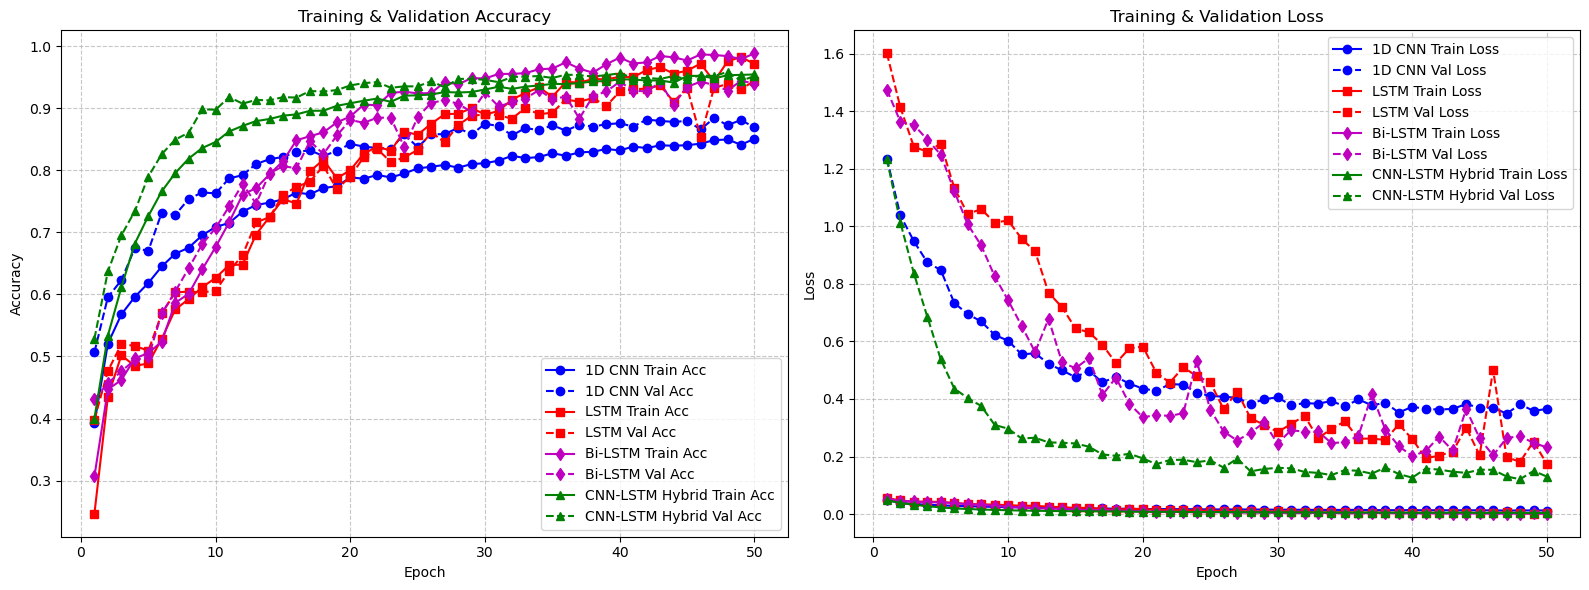

In [25]:
plot_comparison(history_cnn, history_lstm, history_bilstm, history_cnn_lstm)